In [5]:
# 用單個模型同時執行兩個分類任務:
#   age 分成8個classes
#   gender 分成2個classes
# mlp 每個全連接層的unit個數: 512 - 128 -- 8
#                   \_ 2
# trainning: 
#   改用generator產生資料給fit_generator
#   class_weight
#   random_state
#   callback: EarlyStop, model.save

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 20
DROP_RATE = 0.4
model_folder_path = 'drive/My Drive/Tibame_AIoT_Project/face'
img_folder_path = 'drive/My Drive/Tibame_AIoT_Project/Datasets/cleandataset'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# to measure execution time
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1831 sha256=269e9f168a1b7ba49945048807500e5860ce40a5a406f1e8f8cc8d31fa7a6b47
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [8]:
! nvidia-smi

Thu Sep 24 06:29:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 4.8MB/s 
time: 2.52 s


In [10]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 17kB/s 
     |████████████████████████████████| 3.0MB 48.9MB/s 
     |████████████████████████████████| 460kB 48.9MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
time: 1min 58s


In [31]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow import keras
#import keras
#from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, LeakyReLU
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization
from keras.models import Model, Sequential
from keras.regularizers import l1,l2,l1_l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import metrics

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import load_model
import cv2
from glob import glob
import os
from mtcnn import MTCNN
import numpy as np

time: 9.74 ms


In [12]:
print(tf.__version__)
print(keras.__version__)

2.2.0
2.3.0-tf
time: 2.84 ms


In [13]:
# 資料集由csv檔案讀入, 也可新增其他的csv檔案來擴充資料
# df = pd.read_csv('drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/age_gender_wiki.csv')
# df_under10 = pd.read_csv('drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/age_gender_imdb_under10.csv')
# df_over70 = pd.read_csv('drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/age_gender_imdb_over70.csv')
# df = pd.concat([df, df_under10, df_over70])

time: 1.35 ms


In [14]:
# cleandata: 清除wiki資料集原本的一些年齡標註錯誤
df = pd.read_csv(os.path.join(img_folder_path, 'cleandata.csv'))

time: 1.79 s


In [15]:
#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df = df[df['age'] <= 100]
 
#some guys seem to be unborn in the data set
df = df[df['age'] > 0]


time: 16.6 ms


In [16]:
# 每10歲分一類,70歲以上歸為同一類,共8類
df['age_grp'] = pd.cut(df['age'], bins=[0,10,20,30,40,50,60,70,110], right=False)
le = LabelEncoder()
le.fit(df['age_grp'].astype('str'))
df['age_cls'] = le.transform(df['age_grp'].astype('str'))
df

,full_path,gender,age,age_grp,age_cls
0,f10/36890678_1955-04-19_1970.jpg,0,10,"[10, 20)",1
1,f10/36891092_1993-04-22_2012.jpg,0,10,"[10, 20)",1
2,f10/36897260_1993-07-16_2013.jpg,0,10,"[10, 20)",1
3,f10/46804145_1994-05-25_2014.jpg,0,10,"[10, 20)",1
4,f10/46812040_1999-01-05_2014.jpg,0,10,"[10, 20)",1
...,...,...,...,...,...
40098,m0/img_3944_1.jpg,1,5,"[0, 10)",0
40099,m0/img_3944_2.jpg,1,5,"[0, 10)",0
40100,m0/img_3927_2.jpg,1,5,"[0, 10)",0
40101,m0/img_3433_1.jpg,1,5,"[0, 10)",0


time: 359 ms


In [17]:
df['age_cls'].value_counts().sort_index()

0     1883
1     4120
2    11230
3     6518
4     4618
5     4199
6     5074
7     2461
Name: age_cls, dtype: int64

time: 8.81 ms


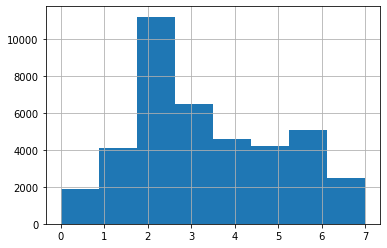

time: 182 ms


In [18]:
histogram_age = df['age_cls'].hist(bins=df['age_cls'].nunique())

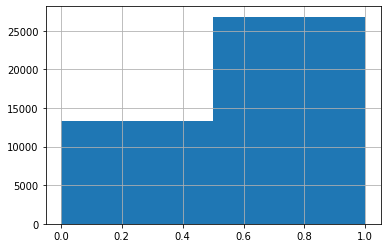

time: 137 ms


In [19]:
histogram_gender = df['gender'].hist(bins=df['gender'].nunique())

In [20]:
s = df.groupby(['gender'])['age_grp'].value_counts()
print(s.index)
print(s.values)
s = s.sort_index()
s

MultiIndex([(0,  [20, 30)),
            (0,  [30, 40)),
            (0,  [10, 20)),
            (0,  [60, 70)),
            (0,  [50, 60)),
            (0, [70, 110)),
            (0,  [40, 50)),
            (0,   [0, 10)),
            (1,  [20, 30)),
            (1,  [30, 40)),
            (1,  [40, 50)),
            (1,  [60, 70)),
            (1,  [50, 60)),
            (1,  [10, 20)),
            (1, [70, 110)),
            (1,   [0, 10))],
           names=['gender', 'age_grp'])
[3407 1887 1815 1678 1484 1120 1065  817 7823 4631 3553 3396 2715 2305
 1341 1066]


gender  age_grp  
0       [0, 10)       817
        [10, 20)     1815
        [20, 30)     3407
        [30, 40)     1887
        [40, 50)     1065
        [50, 60)     1484
        [60, 70)     1678
        [70, 110)    1120
1       [0, 10)      1066
        [10, 20)     2305
        [20, 30)     7823
        [30, 40)     4631
        [40, 50)     3553
        [50, 60)     2715
        [60, 70)     3396
        [70, 110)    1341
Name: age_grp, dtype: int64

time: 128 ms


In [21]:
#因資料不平均, 且多輸出分類器不能用class_weight, 所以只用部分資料來訓練
FULL_DATA = 0
per_cls_trn = 600
# class:  f0  f1  f2   f3  f4  f5   f6  f7  m0  m1  m2   m3   m4   m5   m6   m7
start_idx = [0, 600, 600, 600, 0, 600, 600, 0, 0, 600, 600, 600, 600, 600, 600, 600]
end_idx = np.array(start_idx) + per_cls_trn
print(start_idx, end_idx)
per_cls_eval = 100

#用全部資料
#FULL_DATA = 1

[0, 600, 600, 600, 0, 600, 600, 0, 0, 600, 600, 600, 600, 600, 600, 600] [ 600 1200 1200 1200  600 1200 1200  600  600 1200 1200 1200 1200 1200
 1200 1200]
time: 5.14 ms


In [22]:
#先用少量資料比較不同模型:
#每個類別各取部分資料,用train_test_split來切train and test
df_f0 = df[(df['age_cls'] == 0) & (df['gender'] == 0)]
df_f1 = df[(df['age_cls'] == 1) & (df['gender'] == 0)]
df_f2 = df[(df['age_cls'] == 2) & (df['gender'] == 0)]
df_f3 = df[(df['age_cls'] == 3) & (df['gender'] == 0)]
df_f4 = df[(df['age_cls'] == 4) & (df['gender'] == 0)]
df_f5 = df[(df['age_cls'] == 5) & (df['gender'] == 0)]
df_f6 = df[(df['age_cls'] == 6) & (df['gender'] == 0)]
df_f7 = df[(df['age_cls'] == 7) & (df['gender'] == 0)]
df_m0 = df[(df['age_cls'] == 0) & (df['gender'] == 1)]
df_m1 = df[(df['age_cls'] == 1) & (df['gender'] == 1)]
df_m2 = df[(df['age_cls'] == 2) & (df['gender'] == 1)]
df_m3 = df[(df['age_cls'] == 3) & (df['gender'] == 1)]
df_m4 = df[(df['age_cls'] == 4) & (df['gender'] == 1)]
df_m5 = df[(df['age_cls'] == 5) & (df['gender'] == 1)]
df_m6 = df[(df['age_cls'] == 6) & (df['gender'] == 1)]
df_m7 = df[(df['age_cls'] == 7) & (df['gender'] == 1)]
# train and val data
if FULL_DATA == 1:
    #每個類別保留最後per_cls_eval筆資料作為evaluate用
    train_df = pd.concat([
        df_f0[:-per_cls_eval], df_f1[:-per_cls_eval], df_f2[:-per_cls_eval], df_f3[:-per_cls_eval], 
        df_f4[:-per_cls_eval], df_f5[:-per_cls_eval], df_f6[:-per_cls_eval], df_f7[:-per_cls_eval], 
        df_m0[:-per_cls_eval], df_m1[:-per_cls_eval], df_m2[:-per_cls_eval], df_m3[:-per_cls_eval], 
        df_m4[:-per_cls_eval], df_m5[:-per_cls_eval], df_m6[:-per_cls_eval], df_m7[:-per_cls_eval]         
        ])           
else:    
    #每個類別取同樣數量的資料來訓練
    train_df = pd.concat([
        df_f0[start_idx[0]:end_idx[0]], df_f1[start_idx[1]:end_idx[1]], df_f2[start_idx[2]:end_idx[2]], df_f3[start_idx[3]:end_idx[3]], 
        df_f4[start_idx[4]:end_idx[4]], df_f5[start_idx[5]:end_idx[5]], df_f6[start_idx[6]:end_idx[6]], df_f7[start_idx[7]:end_idx[7]], 
        df_m0[start_idx[8]:end_idx[8]], df_m1[start_idx[9]:end_idx[9]], df_m2[start_idx[10]:end_idx[10]], df_m3[start_idx[11]:end_idx[11]], 
        df_m4[start_idx[12]:end_idx[12]], df_m5[start_idx[13]:end_idx[13]], df_m6[start_idx[14]:end_idx[14]], df_m7[start_idx[15]:end_idx[15]]         
        ])
    
# evaluate data: 每個類別保留最後per_cls_eval筆資料作為evaluate用
eval_df = pd.concat([
        df_f0[-per_cls_eval:], df_f1[-per_cls_eval:], df_f2[-per_cls_eval:], df_f3[-per_cls_eval:], 
        df_f4[-per_cls_eval:], df_f5[-per_cls_eval:], df_f6[-per_cls_eval:], df_f7[-per_cls_eval:],
        df_m0[-per_cls_eval:], df_m1[-per_cls_eval:], df_m2[-per_cls_eval:], df_m3[-per_cls_eval:], 
        df_m4[-per_cls_eval:], df_m5[-per_cls_eval:], df_m6[-per_cls_eval:], df_m7[-per_cls_eval:]         
        ])
x_eval = np.array(eval_df['full_path'])
# 先把模型的兩個輸出的答案合併
y_eval = np.array(pd.concat([eval_df['age_cls'], eval_df['gender']], axis=1))
print("train:", len(train_df), "predict:", len(eval_df))

train: 9600 predict: 1600
time: 102 ms


In [23]:
# 處理答案 把它轉成one-hot (後面再做)
# y_train_category = to_categorical(df['age_cls'], num_classes=8)

# 2個輸出: age, gender
y_df = pd.concat([pd.DataFrame(train_df['age_cls']), pd.DataFrame(train_df['gender'])], axis=1)

# 切分訓練data
x_train, x_test, y_train, y_test = train_test_split(np.array(train_df['full_path']), np.array(y_df), test_size=0.2, random_state=0)

print(x_train[0], x_test[0], y_train[0], y_test[0])
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

m10/catm10_0_8593.jpg m20/8670726_1945-12-09_1972.jpg [1 1] [2 1]
(7680,) (1920,) (7680, 2) (1920, 2)
time: 10.1 ms


In [24]:
detector = MTCNN()
#feature_extractor = load_model(os.path.join(model_folder_path, 'facenet_keras.h5'))

time: 2.35 s


In [25]:
# VGGFace: https://github.com/rcmalli/keras-vggface
!pip install keras_vggface
!pip install keras_applications

from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
feature_extractor = VGGFace(model='vgg16', include_top=False, 
            input_shape=(224, 224, 3), pooling='avg')

     |████████████████████████████████| 51kB 2.5MB/s 
58916864/58909280 [==============================] - 2s 0us/step
time: 7.06 s


In [26]:
feature_extractor.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

In [32]:
# 固定pre-train model的參數
for lyr in feature_extractor.layers:
    lyr.trainable = False

# BN
x = BatchNormalization()(feature_extractor.output)    
    
# MLP    
# x = Flatten()(x)

if DROP_RATE != 0:
    x = Dropout(DROP_RATE)(x)
x = Dense(units=512, activation=LeakyReLU(), kernel_regularizer='l1_l2')(x)

if DROP_RATE != 0:
    x = Dropout(DROP_RATE)(x)
x = Dense(units=128, activation=LeakyReLU(), kernel_regularizer='l1_l2')(x)

if DROP_RATE != 0:
    x = Dropout(DROP_RATE)(x)
age = Dense(units=8, activation='softmax', name='age', kernel_regularizer='l1_l2')(x)
gender = Dense(units=2, activation='softmax', name='gender', kernel_regularizer='l1_l2')(x)

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# 2個輸出: age, gender
age_gender_model = Model(inputs=feature_extractor.input, outputs=[age, gender])   
age_gender_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 224, 224, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 112, 112, 64) 0           conv1_2[0][0]                    
____________________________________________________________________________________________

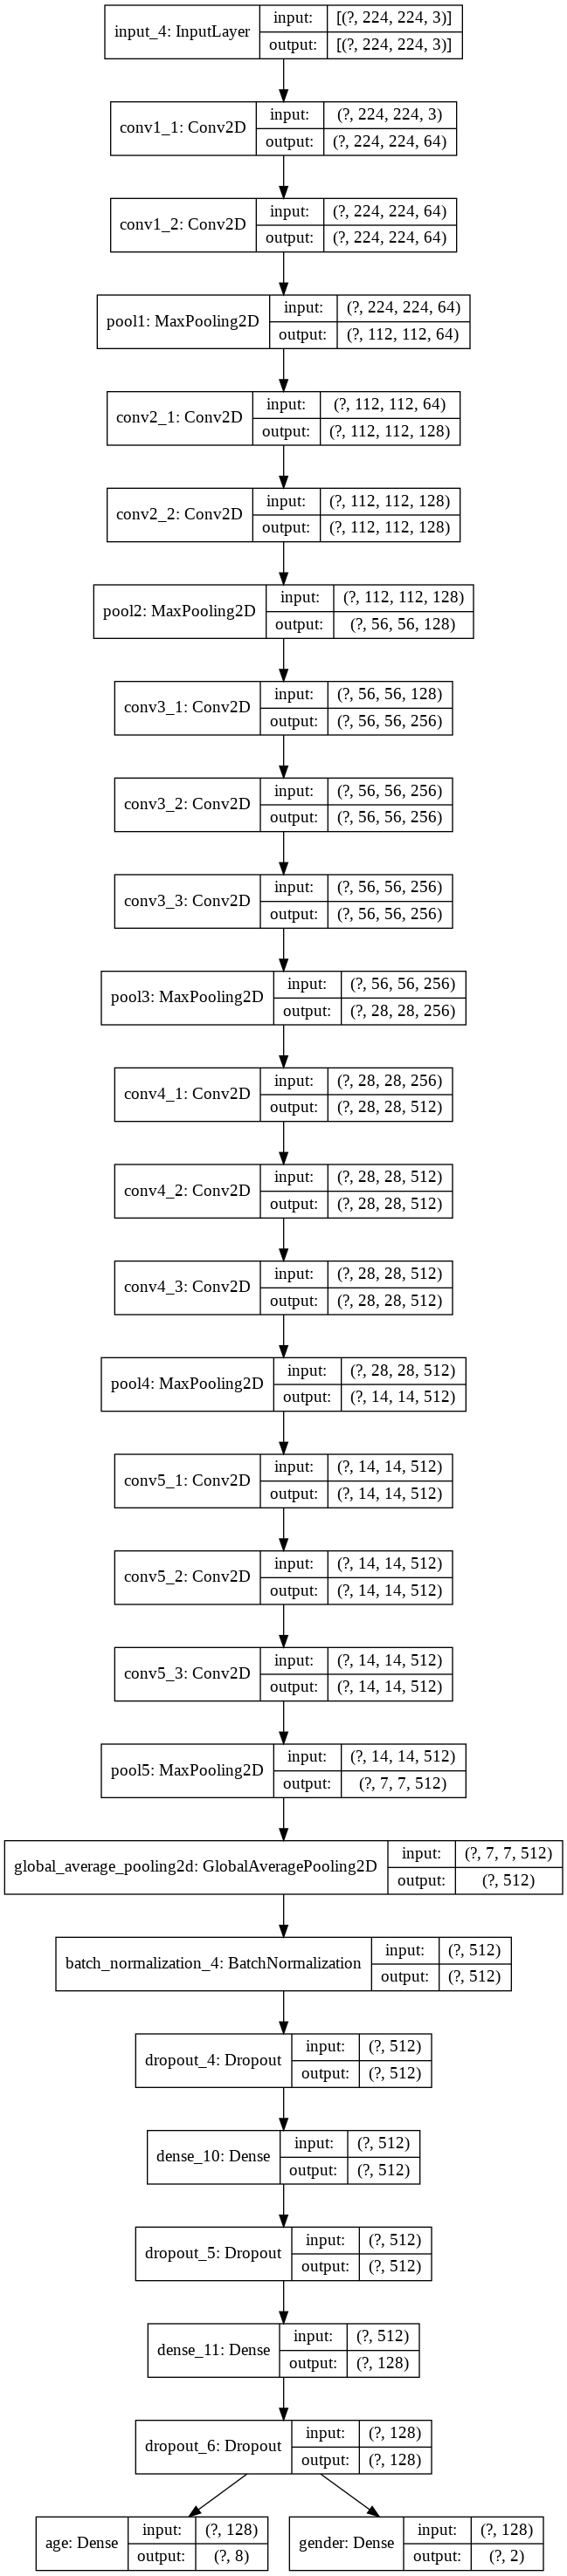

time: 471 ms


In [33]:
from keras.utils import plot_model
plot_model(age_gender_model, show_shapes=True)

In [34]:
age_gender_model.compile(loss=["categorical_crossentropy","categorical_crossentropy"], 
                  optimizer='adam', metrics=[{'age':'accuracy'},{'gender':'accuracy'}]) # 2個輸出: age, gender

age_gender_model = load_model(os.path.join(model_folder_path,'23-4_resnet_mlp512-128_bs64_aug_save.h5'))

time: 9.25 s


In [35]:
# # 資料預處理 for facenet?
# # Standardization
# def preprocess(imgs): 
#     for i in range(imgs.shape[0]):
#         # standardization
#         img = imgs[i]
#         mean, std = img.mean(), img.std()
#         img = (img - mean) / std
#         imgs[i] = img
#     return imgs
# # Normalization
# def normalize(img):
#     return img / 255.

# # -1 <= x <= 1
# def preprocess_1(imgs):
#     x = np.array(imgs, dtype = float)
#     x /= 127.5
#     x -= 1.
#     return x    

time: 2.17 ms


In [36]:
import imgaug.augmenters as iaa
import imgaug as ia
# augmentation
seq = iaa.Sequential([
    #iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
    #iaa.Flipud(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}
        # rotate=(-45, 45),
        # mode=ia.ALL, # edge, reflect, symmetric, warp, constant
        # shear=(-16,16)
    )
])

time: 722 ms


In [37]:
# detect face
def detect_faces(img):
    face_imgs = []

    results = detector.detect_faces(img)
    # extract the bounding box from the first face
    # print('# of faces: ', len(results))
    for i in range(len(results)):
        x1, y1, width, height = results[i]['box']
        x2, y2 = x1 + width, y1 + height
        patch = img[y1:y2, x1:x2] # crop face
        face_imgs.append(patch)
     
    return face_imgs

time: 6.38 ms


In [38]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    """
    Generates data for Keras
    ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    """
    def __init__(self,
                 paths,
                 y_cls,
                 batch_size,
                 #num_classes,
                 shuffle=False,
                 augment=False):
        self.paths = paths
        self.y_cls = y_cls
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        #self.num_classes = num_classes
        self.indexes = np.arange(len(self.paths))
        #self.class_map = {'0':0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7}
        self.on_epoch_end()

    def __len__(self):
        'number of batches per epoch'
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        batch_paths = [self.paths[i] for i in idxs]
        batch_y = [self.y_cls[i] for i in idxs]

        # Generate data
        X, y = self.__data_generation(batch_paths, batch_y)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, paths, y_cls):
        """
        Generates data containing batch_size samples
        """
        # X = np.empty((len(paths), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
        # y = np.empty((len(paths), self.num_classes), dtype=np.float32)

        x_ori, x_norm, y_age, y_gender = [], [], [], []

        for i, path in enumerate(paths):
            #print("idx:", i, "cls:", y_cls[i], path)
        
            # 讀取圖片,切下臉的部分,並使用借來的模型的預處理方式來作預處理 
            try:          
                img = cv2.imread(os.path.join(img_folder_path,path))[:,:,::-1]
            except:
                print('imread failed:', path)
                continue 

            if self.augment:
                img_aug = seq.augment_image(img)
                # print(img_aug.shape)
                # plt.figure(figsize=(10, 10))
                # plt.subplot(1, 2, 1)
                # plt.imshow(img)
                # plt.subplot(1, 2, 2)
                # plt.imshow(img_aug)
                # plt.show()
                
                img = img_aug


            faces = detect_faces(img)
            if len(faces) == 0 or faces[0].shape[0] == 0 or faces[0].shape[1] == 0:
                print(' No face')
                continue
            #print(faces[0].shape)   
            img_crop = cv2.resize(faces[0], (IMG_SIZE, IMG_SIZE))

            # 使用借來的模型的預處理方式來作預處理
            img_pre = preprocess_input(np.array(img_crop,dtype=float))
            
            # 把原圖留下來
            x_ori.append(img)
            x_norm.append(img_pre)
            y_age.append(y_cls[i][0])
            y_gender.append(y_cls[i][1])

            

        # print("len(image_data)",len(x_ori))
        # plt.figure(figsize=(10, 40))
        # for j,m in enumerate(x_ori):
        #     plt.subplot(1, BATCH_SIZE, (j%BATCH_SIZE)+1)
        #     plt.title("idx:{} y_cls:{}".format(i_batch+j, y_cls[i_batch+j]))
        #     plt.axis("off")
        #     plt.imshow(m)
        # plt.show() 

        
        # 2個輸出: age, gender  
        # print(type(y_age), len(y_age), y_age[:8])
        # print(type(y_gender), len(y_gender), y_gender[:8])
        y_age_category = to_categorical(y_age, num_classes=8) 
        y_gender_category = to_categorical(y_gender, num_classes=2) 
        # print(y_age_category)
        # print(y_gender_category)
        x_input = {'input_4':np.array(x_norm)}
        y_category = {'age':np.array(y_age_category), 'gender':np.array(y_gender_category)}
        # print(type(np.array(x_norm)), np.array(x_norm).shape)
        # print(type(y_category), np.array(y_age_category), np.array(y_gender_category))

        #yield x_input, y_category
        return x_input, y_category

time: 115 ms


In [39]:
# 用generator產生資料
generator_train = DataGenerator(x_train, y_train, batch_size=BATCH_SIZE, augment=True)
generator_test = DataGenerator(x_test, y_test, batch_size=BATCH_SIZE)
#type(generator_train)

time: 1.85 ms


In [40]:
# if FULL_DATA == 1:
#     age_weights = {0:12., 1:5., 2:1., 3:2., 4:3., 5:4., 6:6., 7:3.}
# else:    
#     # for temp
#     age_weights = {0:1., 1:1., 2:1., 3:1., 4:1., 5:1., 6:1., 7:1.}

data_count = np.unique(np.argmax(y_train, axis=-1), return_counts=True)[1]
data_count
num_classes=8
age_weights = (1/data_count)*np.sum(data_count)/num_classes
class_weight = {i: w for i, w in enumerate(age_weights)}
print('class_weight', class_weight)

class_weight {0: 0.1333703806612948, 1: 1.991701244813278}
time: 4.92 ms


In [ ]:
# fit_generator
checkpoint = ModelCheckpoint(os.path.join(model_folder_path,"23-5_resnet_mlp512-128_bs64_aug_ep{epoch}_{val_age_accuracy:.4f}_{val_gender_accuracy:.4f}.h5"), 
               save_best_only=False, save_weights_only=False)   #Defaults: save_freq='epoch', save_weights_only=False
earlystop = EarlyStopping(patience=5, restore_best_weights=True)
#logs = age_gender_model.fit_generator(
logs = age_gender_model.fit( 
        generator_train,
        #steps_per_epoch=len(x_train)//BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=generator_test,
        #validation_steps=len(x_test)//BATCH_SIZE,
        #class_weight = class_weight,    # `class_weight` is only supported for Models with a single output.
        callbacks=[checkpoint, earlystop] 
        )

 No face
 No face
Epoch 1/20
 No face
  2/120 [..............................] - ETA: 49:10 - loss: 1.2580 - age_loss: 1.1773 - gender_loss: 0.0807 - age_accuracy: 0.5118 - gender_accuracy: 0.9764WARNING:tensorflow:5 out of the last 29 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fdde4e33d08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
 No face
 No face
  4/120 [>.............................] - ETA: 1:03:59 - loss: 1.1410 - age_loss: 1.0653 - gender_loss: 0.0757 - age_accuracy: 0.5675 - gender_accuracy: 0.9722WARNING:tensorflow:5 out of the last 5

In [ ]:
age_gender_model.save(os.path.join(model_folder_path,'23-5_resnet_mlp512-128_bs64_aug_save.h5'))

In [ ]:
model = load_model(os.path.join(model_folder_path,"23-5_resnet_mlp512-128_bs64_aug_save.h5"))

In [ ]:
history = logs.history
history

In [ ]:
plt.plot(history['age_accuracy'])
plt.plot(history['val_age_accuracy'])
plt.legend(['age_accuracy', 'val_age_accuracy'])
plt.title('age_accuracy')
plt.show()

In [ ]:
plt.plot(history['gender_accuracy'])
plt.plot(history['val_gender_accuracy'])
plt.legend(['gender_accuracy', 'val_gender_accuracy'])
plt.title('gender_accuracy')

In [ ]:
plt.plot(history['age_loss'])
plt.plot(history['val_age_loss'])
plt.legend(['age_loss', 'val_age_loss'])
plt.title('age_loss')

In [ ]:
plt.plot(history['gender_loss'])
plt.plot(history['val_gender_loss'])
plt.legend(['gender_loss', 'val_gender_loss'])
plt.title('gender_loss')

In [ ]:
!pip install keras2onnx

In [ ]:
# convert to onnx model
import keras2onnx
onnx_model = keras2onnx.convert_keras(age_gender_model, age_gender_model.name)

In [ ]:
keras2onnx.save_model(onnx_model, os.path.join(model_folder_path,'23-5_resnet_mlp512-128_aug.onnx'))

In [ ]:
# 取得要預測的圖片並做預處理
def get_preprocess_images(data_paths, y_data, batch_size=BATCH_SIZE):
    n = len(data_paths)
    # i = 0
    # data_paths = data_paths
    
    #while i < n:    
    x_ori, x_norm, y_age, y_gender = [], [], [], []
    #i_batch = i
    for idx in range(batch_size):
        path = data_paths[idx]
        #print("n:", n, "idx:", i, "cls:", y_data[i], path)
    
        # 讀取圖片,切下臉的部分,並使用借來的模型的預處理方式來作預處理 
        try:          
            img = cv2.imread(os.path.join(img_folder_path,path))[:,:,::-1]
        except:
            print('imread failed:', path)
            idx = idx + 1
            continue                   
        
        faces = detect_faces(img)
        if len(faces) == 0 or faces[0].shape[0] == 0 or faces[0].shape[1] == 0:
            print('No face')
            idx = idx + 1
            continue   
        # print(faces[0].shape)    
        img_crop = cv2.resize(faces[0], (IMG_SIZE, IMG_SIZE))
        

        # 使用借來的模型的預處理方式來作預處理
        img_pre = preprocess_input(np.array(img_crop, dtype=float))

        # 把原圖留下來
        x_ori.append(img)
        x_norm.append(img_pre)
        if len(y_data) != 0:
            y_age.append(y_data[idx][0])
            y_gender.append(y_data[idx][1])
        
        idx = idx + 1


    # print("len(image_data)",len(x_ori))
    # plt.figure(figsize=(10, 40))
    # for j,m in enumerate(x_ori):
    #     plt.subplot(1, BATCH_SIZE, (j%BATCH_SIZE)+1)
    #     plt.title("idx:{} y_data:{}".format(i_batch+j, y_data[i_batch+j]))
    #     plt.axis("off")
    #     plt.imshow(m)
    # plt.show() 

    
    # 2個輸出: age, gender  
    # print(type(y_age), len(y_age), y_age[:8])
    # print(type(y_gender), len(y_gender), y_gender[:8])
    if len(y_data) != 0:
        y_age_category = to_categorical(y_age, num_classes=8) 
        y_gender_category = to_categorical(y_gender, num_classes=2) 
        y_category = {'age':np.array(y_age_category), 'gender':np.array(y_gender_category)}
    else:
        y_category = []

    # print(type(np.array(x_norm)), np.array(x_norm).shape)
    # print(type(y_category), np.array(y_age_category), np.array(y_gender_category))

    return np.array(x_ori), np.array(x_norm), y_category
    #print('while end', i, n)

In [ ]:
# evaluate
#
# 從保留作為evaluate用的資料,用generator產生資料 to predict
x_ori, x_input, y_category = get_preprocess_images(x_eval, y_eval, batch_size=len(x_eval))

# 取出圖片資料與正確答案
x_eval_data, y_true_age, y_true_gender = [], [], []
for i,x in enumerate(x_input):
    # print("x_eval_data:", len(list(x_dict['input_4'])))
    x_eval_data.append(x)
    # print("y_true_age:", y_dict['age'].argmax(axis=-1))
    # print("y_true_gender:", y_dict['gender'].argmax(axis=-1))    
    y_true_age.append( (list(y_category['age'])[i].argmax(axis=-1)) )
    y_true_gender.append( (list(y_category['gender'])[i].argmax(axis=-1)) )

# print("-------------------------")
print("x_eval_data:", type(x_eval_data), "np.array:", np.array(x_eval_data).shape, x_eval[:8])
print("y_true_age:", y_true_age)
print("y_true_gender:", y_true_gender)

In [ ]:
# predict
pre = age_gender_model.predict(np.array(x_eval_data))
#pre[0] is predicted probabilities for age
#pre[1] is predicted probabilities for gender
pred_age = pre[0].argmax(axis=-1)
pred_gender = pre[1].argmax(axis=-1)
print("predict age:",pred_age)
print("predict gender:",pred_gender)

In [ ]:
len(pred_age), len(pred_gender)

In [ ]:
from sklearn.metrics import classification_report
print(np.array(y_true_age).shape, np.array(pred_age).shape, np.array(y_true_gender).shape, np.array(pred_gender).shape)
age_target_names = [str(i) for i in range(8)]
gender_target_names = [str(i) for i in range(2)]
print(classification_report(np.array(y_true_age), np.array(pred_age), target_names=age_target_names))
print(classification_report(np.array(y_true_gender), np.array(pred_gender), target_names=gender_target_names))

In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_true_age, pred_age),
            index=["{}(真實)".format(i) for i in range(8)],
            columns=["{}(預測)".format(i) for i in range(8)] 
            )

In [ ]:
pd.DataFrame(confusion_matrix(y_true_gender, pred_gender),
            index=["{}(真實)".format(i) for i in range(2)],
            columns=["{}(預測)".format(i) for i in range(2)] 
            )